## Getting started

To run this analysis, work through this notebook starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
from pathlib import Path

import rasterio.features
from shapely.geometry import Polygon, shape, mapping, MultiPolygon
from shapely.ops import unary_union
import geopandas as gp
import fiona
from fiona.crs import from_epsg
import xarray as xr
import pandas as pd
import glob
import os.path
import math
import geohash as gh
import re
import datacube
import rioxarray
import matplotlib.pyplot as plt
import numpy as np
from deafrica_tools.spatial import xr_vectorize, xr_rasterize
from deafrica_tools.datahandling import wofs_fuser, mostcommon_crs
from deafrica_tools.plotting import display_map, map_shapefile
from datacube.utils.geometry import Geometry, CRS

/usr/local/lib/python3.10/dist-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_292/2123682862.py:6: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling 

## Analysis parameters

This section lets you set parameters for the analysis.

<a id='wetnessThreshold'></a>
### How frequently wet does a pixel need to be to be included?
The value/s set here will be the minimum frequency (as a decimal between 0 and 1) that you want water to be detected across all analysis years before it is included. 

E.g. If this was set to 0.10, any pixels that are wet *at least* 10% of the time across all valid observations will be included. If you don't want to use this filter, set this value to 0.

Following the exploration of an appropriate wetness threshold for DEA Waterbodies ([see here](DEA_Waterbodies_supplement/DEAWaterbodiesThresholdSensitivityAnalysis.ipynb)), we choose to set two thresholds here. The code is set up to loop through both wetness thresholds, and to write out two temporary shapefiles. These two shapefiles with two separate thresholds are then used together to combine polygons from both thresholds later on in the workflow.

Polygons identified by the secondary threshold that intersect with the polygons generated by the primary threshold will be extracted, and included in the final polygon dataset. This means that the **location** of polygons is set by the primary threshold, but the **shape** of these polygons is set by the secondary threshold.

Threshold values need to be provided as a list of either one or two floating point numbers. If one number is provided, then this will be used to generate the initial polygon dataset. If two thresholds are entered, the **first number becomes the secondary threshold, and the second number becomes the primary threshold**. If more than two numbers are entered, the code will generate an error below. 

In [2]:
minimum_wet_percentage = [0.05, 0.1]

<a id='size'></a>
### How big/small should the polygons be?
This filtering step can remove very small and/or very large waterbody polygons. The size listed here is in m2. A single pixel in Landsat data is 30 m X 30 m = 900 m2. 

**MinSize**

E.g. A minimum size of 2700 means that polygons need to be at least 3 pixels to be included. If you don't want to use this filter, set this value to 0.

**MaxSize**

E.g. A maximum size of 1 000 000 means that you only want to consider polygons less than 1 km2. If you don't want to use this filter, set this number to `math.inf`. 

*NOTE: if you are doing this analysis for all of Australia, very large polygons will be generated offshore, in the steps prior to filtering by the Australian coastline. For this reason, we have used a `MaxSize` = Area of Kati Thanda-Lake Eyre. This will remove the huge ocean polygons, but keep large inland waterbodies that we want to map.*

In [3]:
min_area_m2 = 2700 # 3 Landsat pixels 
max_area_m2 = 5000000000

<a id='valid'></a>
### Filter results based on number of valid observations

The total number of valid WOfS observations for each pixel varies depending on the frequency of clouds and cloud shadow, the proximity to high slope and terrain shadow, and the seasonal change in solar angle. 

The `count_clear` parameter within the [`wofs_ls_summary_alltime`](https://explorer.digitalearth.africa/products/wofs_ls_summary_alltime) data provides a count of the number of valid observations each pixel recorded over the analysis period. We can use this parameter to mask out pixels that were infrequently observed. 
If this mask is not applied, pixels that were observed only once could be included if that observation was wet (i.e. a single wet observation means the calculation of the frequency statistic would be (1 wet observation) / (1 total observation) = 100% frequency of wet observations).

Here we set the minimum number of observations to be 128 (roughly 4 per year over our 32 year analysis). Note that this parameter does not specify the timing of these observations, but rather just the **total number of valid observations** (observed at any time of the year, in any year).

In [4]:
min_valid_observations = 128

This filter can be applied before or after aggregating polygons. If you would like to apply this filter *after* the polygons have been aggregated, specify `False` here:

In [5]:
apply_min_valid_observations_first = True

### Splitting large polygons

There are currently two methods for splitting large polygons:

- Use the Polsby-Popper test, then erode/dilate
- Don't do that

Choose one of those:

In [6]:
handle_large_polygons = 'erode-dilate-v2'

In [7]:
# Check that's a valid method for handling.
large_polygon_options = {'erode-dilate-v1', 'erode-dilate-v2', 'nothing'}
assert handle_large_polygons in large_polygon_options

You also need to specify a threshold for the Polsby-Popper test above which polygons won't be split (DE Australia Waterbodies uses 0.005):

In [8]:
pp_thresh = 0.005

<a id='Tiles'></a>
### Set up the input datasets for the analysis

#### Load and plot area of interest

We have a geojson file which defines a polygon for the area of interest for this analysis. We can see the county name and other details below. We can then plot the bounds of the area and map the shapefile to see the area we are working on.

In [9]:
area = gp.read_file('testing_workflow/data/nakuru_kenya.geojson').to_crs("epsg:6933")
area

,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
0,KEN.31_1,KEN,Kenya,Nakuru,NA,NA,County,County,32,KE.NK,KE-31,"MULTIPOLYGON (((3524304.711 -145483.447, 35239..."


In [10]:
geom = Geometry(geom=area.iloc[0].geometry, crs="epsg:6933")

In [11]:
map_shapefile(area, attribute = area.columns[0])

Label(value='')

Map(center=[-0.45440682649283065, 36.00700378400006], controls=(ZoomControl(options=['position', 'zoom_in_text…

In [12]:
# lat = -0.3227
# lon = 36.0242

# # buffering distance around the central location defined by lat and lon
# buffer =  0.5

# lat_range = (lat - buffer, lat + buffer)
# lon_range = (lon - buffer, lon + buffer)

In [13]:
# lat_range

In [14]:
# xlim = [35.5242, 36.5242] 
# ylim = [-0.8227, 0.1773]

In [15]:
# display_map(x=xlim, y=ylim)

### Output filename

Specify the output base filename:

In [16]:
base_filename = 'waterbodies'

## Generate the first polygon dataset

This is the first set of polygons with no filtering.

Remove any previous runs of this code, and set up an output directory for the new results.

In [17]:
%%bash
rm -rf _wb_outputs
mkdir _wb_outputs

In [18]:
intermediate_wb_path = Path('testing_workflow/_wb_outputs/')

Check we have set all our analysis parameters correctly

In [19]:
# First, test whether the wetness threshold has been correctly set
if len(minimum_wet_percentage) == 2:
    print(
        f'We will be running a hybrid wetness threshold. Please ensure that the major threshold is \n'
        f'listed second, with the supplementary threshold entered first.'
        f'**You have set {minimum_wet_percentage[-1]} as the detection threshold,** \n'
        f'**with {minimum_wet_percentage[0]} set as the extent threshold.**')
elif len(minimum_wet_percentage) == 1:
    print(
        f'You have not set up the hybrid threshold option. If you meant to use this option, please \n'
        f'set this option by including two wetness thresholds in the `AtLeastThisWet` variable above. \n'
        f'The wetness threshold we will use is {minimum_wet_percentage}.')
else:
    raise ValueError(
        f'There is something wrong with your entered wetness threshold. Please enter a list \n'
        f'of either one or two numbers. You have entered {minimum_wet_percentage}. \n'
        f'See above for more information')

We will be running a hybrid wetness threshold. Please ensure that the major threshold is 
listed second, with the supplementary threshold entered first.**You have set 0.1 as the detection threshold,** 
**with 0.05 set as the extent threshold.**


#### Load up WOfS: 

In [20]:
# Set up the datacube to get DE Africa data.
dc = datacube.Datacube(app='WaterbodyPolygons')

# Some query parameters.
dask_chunks = {'x': 3000, 'y': 3000, 'time': 1}
resolution = (-30, 30)  # This is the resolution of WOfS, which changes depending on which collection you use.

# # Then load the WOfS summary of clear/wet observations:
wofs_ = dc.load('wofs_ls_summary_alltime', 
                geopolygon = geom, 
                dask_chunks=dask_chunks)
wofs = wofs_.isel(time=0)

# And set the no-data values to nan:
wofs = wofs.where(wofs != -1)
mask = xr_rasterize(area, wofs)
wofs = wofs.where(mask)

Then load the mask for filtering minimum valid observations. We can compute this now even if we don't want to aggregate after filtering, because we'll still need it later.

In [21]:
# Filter pixels with at least min_valid_observations times.
wofs_valid_filtered = wofs.count_clear >= min_valid_observations

In [22]:
for threshold in minimum_wet_percentage:
    # Remove any pixels that are wet < AtLeastThisWet% of the time
    wofs_filtered = wofs.frequency > threshold

    # Now find pixels that meet both the minimum valid observations and wetness percentage criteria
    # Change all zeros to NaN to create a nan/1 mask layer
    # Pixels == 1 now represent our water bodies
    if apply_min_valid_observations_first:
        wofs_filtered = wofs_filtered.where(wofs_filtered & wofs_valid_filtered)
    else:
        wofs_filtered = wofs_filtered.where(wofs_filtered)
    
    # Vectorise the raster.
    polygons = xr_vectorize((wofs_filtered == 1).values, crs='EPSG:6933', transform=wofs.rio.transform())
    polygons = polygons[polygons.attribute == 1].reset_index(drop=True)

    # Combine any overlapping polygons
    polygons = polygons.geometry.buffer(0).unary_union

    # Turn the combined multipolygon back into a geodataframe
    polygons = gp.GeoDataFrame(
        geometry = list(polygons.geoms))
#         geometry=[poly for poly in polygons])

    # We need to add the crs back onto the dataframe
    polygons.crs = 'EPSG:6933'

    # Calculate the area of each polygon again now that overlapping polygons
    # have been merged
    polygons['area'] = polygons.area
    
    # Save the polygons to a shapefile
    filename = intermediate_wb_path / f'{base_filename}_raw_{threshold}.shp'
    polygons.to_file(filename)

We can then look at all of the polygons we have found so far, from which we will extract our waterbodies:

<Axes: >

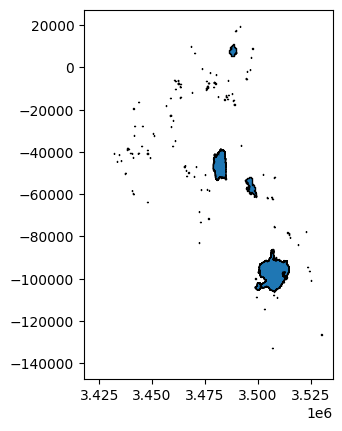

In [23]:
gp.read_file(filename).plot(edgecolor='k')

<a id='Filtering'></a>

## Filter the merged polygons by area, coastline, CBD, and wetness

### Filtering by area

In [24]:
if len(minimum_wet_percentage) == 2:
    polygons = gp.read_file(intermediate_wb_path / f'{base_filename}_raw_{minimum_wet_percentage[1]}.shp')
else:
    polygons = gp.read_file(intermediate_wb_path / f'{base_filename}_raw_{minimum_wet_percentage[0]}.shp')

In [25]:
# Filter polygons by size.
polygons = polygons[(polygons['area'] >= min_area_m2) & (polygons['area'] <= max_area_m2)]

<Axes: >

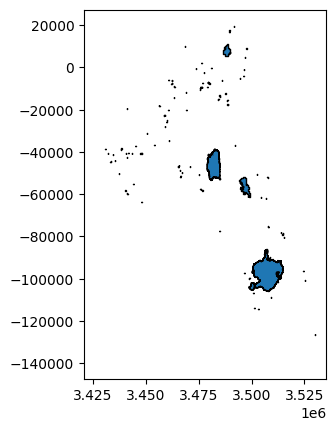

In [26]:
polygons.plot(edgecolor='k')

### Combine detected polygons with their maximum extent boundaries

In [28]:
# Check for hybrid wetness thresholds
if len(minimum_wet_percentage) == 2:
    
    # Note that this assumes that the thresholds have been correctly entered into the 'minimum_wet_percentage'
    # variable, with the extent threshold listed first.
    lower_threshold = gp.read_file(
        intermediate_wb_path / f'{base_filename}_raw_{minimum_wet_percentage[0]}.shp')
    lower_threshold['area'] = pd.to_numeric(lower_threshold.area)
    
    # Filter out those pesky huge polygons
    lower_threshold = lower_threshold.loc[(lower_threshold['area'] <= max_area_m2)]
    lower_threshold['lt_index'] = range(len(lower_threshold))
    
    # Pull out the polygons from the extent shapefile that intersect with the detection shapefile
    overlay_extent = gp.overlay(polygons, lower_threshold)
    lower_threshold_to_use = lower_threshold.loc[overlay_extent.lt_index]
    
    # Combine the polygons
    polygons = gp.GeoDataFrame(pd.concat([lower_threshold_to_use, polygons], ignore_index=True))
   
    # Merge overlapping polygons
    polygons = polygons.unary_union
    
    # Back into individual polygons
    polygons = gp.GeoDataFrame(crs='EPSG:6933', geometry=[polygons]).explode()

/tmp/ipykernel_292/4120195622.py:15: UserWarning: `keep_geom_type=True` in overlay resulted in 19 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  overlay_extent = gp.overlay(polygons, lower_threshold)
/tmp/ipykernel_292/4120195622.py:25: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  polygons = gp.GeoDataFrame(crs='EPSG:6933', geometry=[polygons]).explode()


In [29]:
# Get rid of the multiindex that explode added:
polygons = polygons.reset_index(drop=True)

In [30]:
# Add area, perimeter, and polsby-popper columns:
polygons['area'] = polygons.area
polygons['perimeter'] = polygons.length
polygons['pp_test'] = polygons.area * 4 * math.pi / polygons.perimeter ** 2

In [31]:
# Dump the merged polygons to a file:
polygons.to_file(intermediate_wb_path / f'{base_filename}_merged.shp')
polygons.to_file(intermediate_wb_path / f'{base_filename}_merged.geojson', driver='GeoJSON')

We now have the 5% extent for all polygons detected at a 10% level:

<Axes: >

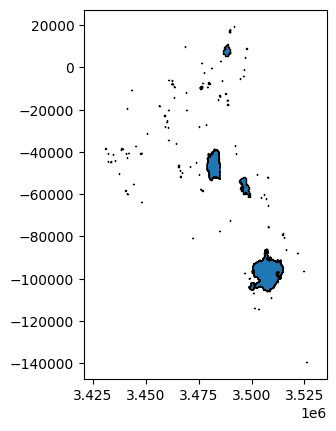

In [32]:
gp.read_file(intermediate_wb_path / f'{base_filename}_merged.shp').plot(edgecolor='k')

### Dividing up very large polygons

The size of polygons is determined by the contiguity of waterbody pixels through the landscape. This can result in very large polygons, e.g. where rivers are wide and unobscured by trees, or where waterbodies are connected to rivers or neighbouring waterbodies.

We do this by applying the [Polsby-Popper test (1991)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2936284). The Polsby-Popper test is an assessment of the 'compactness' of a polygon. This method was originally developed to test the shape of congressional and state legislative districts, to prevent gerrymandering. 

The Polsby-Popper test examines the ratio between the area of a polygon, and the area of a circle equal to the perimeter of that polygon. The result falls between 0 and 1, with values closer to 1 being assessed as more compact.

\begin{align*}
PPtest = \frac{polygon\ area * 4\pi}{polygon\ perimeter^2}
\end{align*}

The Menindee Lakes polygon has a PPtest value $\approx$ 0.00. 

We selected all polygons with a `PPtest` value <=0.005. This resulted in a subset of 186 polygons continent-wide.

<Axes: >

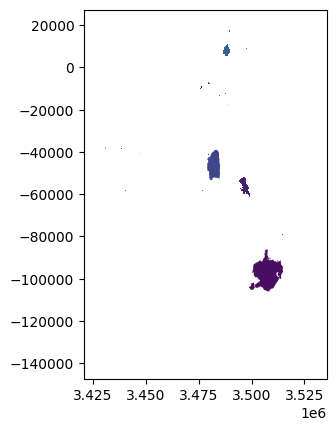

In [33]:
polygons.plot(column='pp_test')

How many polygons in our test region fall below the Polsby-Popper threshold?

In [34]:
(polygons.pp_test <= pp_thresh).sum()

0

The **186 polygons** were buffered with a -50 meter (2 pixel) buffer to separate the polygons where they are connected by two pixels or less. This allows us to split up these very large polygons by using natural thinning points. The resulting negatively buffered polygons was run through the `multipart to singlepart` tool in QGIS, to give the now separated polygons unique IDs. 

These polygons were then buffered with a +50 meter buffer to return the polygons to approximately their original size. These final polygons were used to separate the 186 original polygons identified above.

The process for dividing up the identified very large polygons varied depending on the polygon in question. Where large waterbodies were connected, the buffered polygons were used to determine the cut points in the original polygons.

The buffering method didn't work on large segments of river, which became a series of disconnected pieces when negatively and positively buffered. Instead, we used a combination of tributaries and man-made features such as bridges and weirs to segment these river sections.

If `handle_large_polygons = 'erode-dilate-v1`, then we will attempt to replicate DEA Waterbodies as above. If it's `erode-dilate-v2`, we'll do a slightly different method designed for full automation, but this is not yet implemented. If it's `nothing` we'll do nothing.

In [35]:
if handle_large_polygons == 'erode-dilate-v1':
    needs_buffer = polygons[polygons.pp_test <= pp_thresh]
    unbuffered = needs_buffer.buffer(-50)
    unbuffered = unbuffered.explode().reset_index(drop=True).buffer(50)
    unbuffered = gp.GeoDataFrame(geometry=unbuffered, crs='EPSG:6933')
    unbuffered['area'] = unbuffered.area
    unbuffered['perimeter'] = unbuffered.length
    unbuffered['pp_test'] = unbuffered.area * 4 * math.pi / unbuffered.perimeter ** 2
    polygons = pd.concat([polygons[polygons.pp_test > pp_thresh], unbuffered], ignore_index=True)

v2 is more expensive but doesn't require manual intervention. Start with the original polygon set $P$. Unbuffer by a few pixels and then buffer by one extra pixel, so we have a slightly larger version of the original but split up and without small polygons; call this $Q$. Subtract this from the original polygon set to obtain the subtracted set $P - Q$. Subtract _this_ set to obtain $P - (P - Q)$, noting that this isn't just $P$ because these are set operations. This gives a non-rounded version of the original large polygons that have been split up. We then just need to add back in the small bits that were chopped off, which we can do by assigning each to their nearest neighbour.

In [36]:
if handle_large_polygons == 'erode-dilate-v2':
    splittable = polygons[polygons.pp_test <= pp_thresh]
    if len(splittable) >= 1:
        unbuffered = splittable.buffer(-100)
        buffered = unbuffered.buffer(125)
        subtracted = gp.overlay(splittable, gp.GeoDataFrame(geometry=[buffered.unary_union], crs=splittable.crs), how='difference').explode().reset_index(drop=True)
        resubtracted = gp.overlay(splittable, subtracted, how='difference').explode().reset_index(drop=True)

        # Assign each chopped-off bit of the polygon to its nearest big neighbour.
        unassigned = np.ones(len(subtracted), dtype=bool)
        recombined = []
        for i, poly in resubtracted.iterrows():
            mask = subtracted.exterior.intersects(poly.geometry.exterior) & unassigned
            neighbours = subtracted[mask]
            unassigned[mask] = False
            poly = poly.geometry.union(neighbours.unary_union)
            recombined.append(poly)    

        # All remaining polygons are not part of a big polygon.
        results = pd.concat([gp.GeoDataFrame(geometry=recombined), subtracted[unassigned], polygons[polygons.pp_test > pp_thresh]], ignore_index=True)

        polygons = results.explode().reset_index(drop=True)

In [37]:
if handle_large_polygons == 'nothing':
    print('Not splitting large polygons')

Here is the most complex polygon after the splitting step:

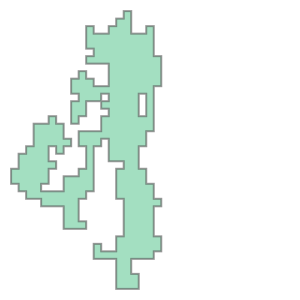

In [38]:
polygons.iloc[polygons.pp_test.argmin()].geometry

## Make sure every polygon has a minimum number of observations

Similar to how we applied the ocean mask, we will now remove all polygons that don't have a minimum number of observations attained within them.

In [39]:
if not apply_min_valid_observations_first:
    polygons['one_idx'] = range(1, len(polygons) + 1)
    polygon_mask = xr_rasterize(polygons, wofs, attribute_col='one_idx')
    counts = []
    for i in polygons.one_idx:
        mask = polygon_mask == i
        count = wofs.count_clear.values[mask].max()
        counts.append(count)
    polygons['n_valid_observations'] = counts
    polygons = polygons[polygons.n_valid_observations >= min_valid_observations]

We have now excluded polygons with a small number of observations:

<Axes: >

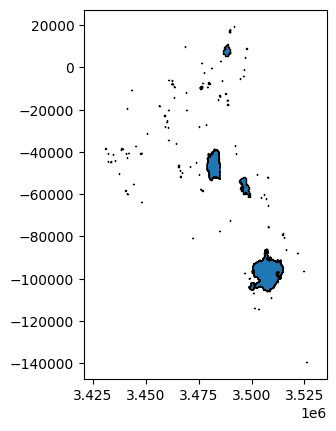

In [40]:
polygons.plot(edgecolor='k')

### Generate a unique ID for each polygon

A unique identifier is required for every polygon to allow it to be referenced. The naming convention for generating unique IDs here is the [geohash](geohash.org).

A Geohash is a geocoding system used to generate short unique identifiers based on latitude/longitude coordinates. It is a short combination of letters and numbers, with the length of the string a function of the precision of the location. The methods for generating a geohash are outlined [here - yes, the official documentation is a wikipedia article](https://en.wikipedia.org/wiki/Geohash).

Here we use the python package `python-geohash` to generate a geohash unique identifier for each polygon. We use `precision = 9` geohash characters, which represents an on the ground accuracy of <20 metres. This ensures that the precision is high enough to differentiate between waterbodies located next to each other.

In [41]:
# We need to convert from coordinates to lat/lon, in order to generate the geohash
polygons_4326 = polygons.to_crs(epsg=4326)

# Generate a geohash for the centroid of each polygon
polygons_4326['UID'] = polygons_4326.apply(lambda x: gh.encode(x.geometry.centroid.y, x.geometry.centroid.x, precision=9), axis=1)

# Check that our unique ID is in fact unique
assert polygons_4326['UID'].is_unique

# Make an arbitrary numerical ID for each polygon. We will first sort the dataframe by geohash
# so that polygons close to each other are numbered similarly
sorted_polygons = polygons_4326.sort_values(by=['UID']).reset_index()
sorted_polygons['WB_ID'] = sorted_polygons.index

In [42]:
# The step above creates an 'index' column, which we don't actually want, so drop it.
sorted_polygons.drop(labels='index', axis=1, inplace=True)

In [43]:
polygons = sorted_polygons.to_crs('EPSG:6933')

### Write out the final results to a shapefile

<Axes: >

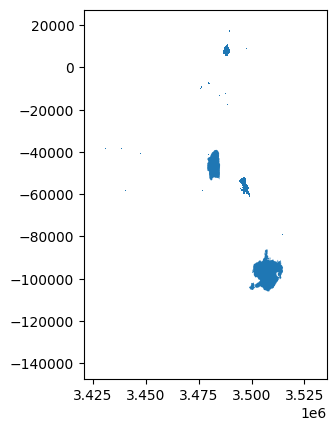

In [44]:
polygons.plot()

In [45]:
polygons

,geometry,area,perimeter,pp_test,UID,WB_ID
0,"POLYGON ((3526050.000 -139350.000, 3526050.000...",4500.0,300.0,0.628319,kzccz94s3,0
1,"POLYGON ((3527580.000 -139470.000, 3527580.000...",6300.0,420.0,0.448799,kzcczbyqe,1
2,"POLYGON ((3526650.000 -137580.000, 3526650.000...",9000.0,540.0,0.387851,kzcczexpx,2
3,"POLYGON ((3507000.000 -132900.000, 3507000.000...",3600.0,300.0,0.502655,kzcf5475e,3
4,"POLYGON ((3497490.000 -113250.000, 3497430.000...",5400.0,300.0,0.753982,kzcfby7nm,4
...,...,...,...,...,...,...
237,"POLYGON ((3489720.000 16980.000, 3489750.000 1...",18900.0,840.0,0.336599,sb18z009z,237
238,"POLYGON ((3491550.000 19230.000, 3491550.000 1...",4500.0,360.0,0.436332,sb18z7w9w,238
239,"POLYGON ((3495930.000 2880.000, 3495930.000 28...",13500.0,600.0,0.471239,sb1b0kpqq,239
240,"POLYGON ((3497010.000 4620.000, 3497040.000 46...",27900.0,780.0,0.576268,sb1b0wrx0,240
